<a href="https://colab.research.google.com/github/SamKernich/Projects/blob/main/CNN/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from torchsummary import summary
!pip install torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

"""
Link to original dataset.
https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data

Each image has the original cityscape (left) and the target mask (right) of the image file.
"""
path = kagglehub.dataset_download("dansbecker/cityscapes-image-pairs")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def set_seed(i):
  random.seed(i)
  np.random.seed(i)
  torch.manual_seed(i)
  if device == 'cuda':
    torch.cuda.manual_seed(i)
    torch.cuda.manual_seed_all(i)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Path to dataset files:", path)



Using Colab cache for faster access to the 'cityscapes-image-pairs' dataset.
Path to dataset files: /kaggle/input/cityscapes-image-pairs


In [3]:
# If the downloaded kaggle directory contains an extra nested layer, join from the root
if len(os.listdir(path)) == 1 and os.path.isdir(os.path.join(path, os.listdir(path)[0])):
    path = os.path.join(path, os.listdir(path)[0])


train_pth = os.path.join(path, "train")
val_pth = os.path.join(path, "val")

set_seed(42)
train_imgs = os.listdir(train_pth)
val_imgs = os.listdir(val_pth)

set_seed(42)
val_imgs, test_imgs = random_split(val_imgs, [450,50])


print(len(train_imgs), len(val_imgs), len(test_imgs))

2975 450 50


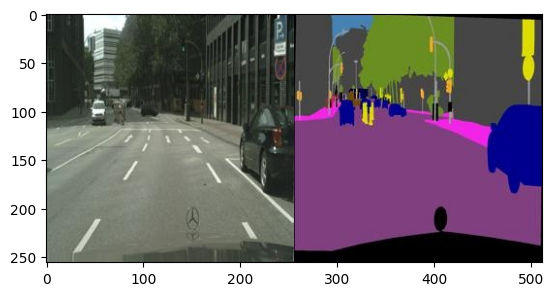

Width: 512, Height: 256


In [4]:
sample = Image.open(os.path.join(train_pth, train_imgs[0]))
plt.imshow(sample)
plt.show()
print(f"Width: {sample.width}, Height: {sample.height}")

In [5]:
def split_images(img):
  """
  Split the input image into the cityscape and the mask.
  """
  img = np.array(img)
  city, mask = img[:, :256 ,: ], img[:, 256:, :]
  return city, mask


In [6]:
"""
https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
^ For the helper file labelling the classes into RGB
"""
!pip install cityscapesscripts
from cityscapesscripts.helpers import labels as helper_labels

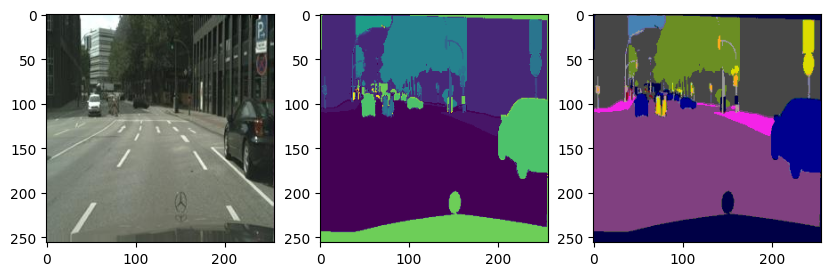

In [7]:
labels = helper_labels.labels

# Create a color to label mapping
color_label = {label.color: label.trainId for label in labels if not label.ignoreInEval}


def rgb_to_label(mask):
  """
  This function converts a 3 channel RGB mask to an integer encoded 2D labelled
  mask that can be used for training.
  """
  if type(mask) == Image:
      mask = np.array(mask)
  label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)
  colors = np.array(list(color_label.keys()))  # shape (num_classes, 3)

  for y in range(mask.shape[1]):
    for x in range(mask.shape[0]):
      rgb = mask[y, x]

      dist = np.linalg.norm(colors - rgb, axis=1)
      min = np.argmin(dist)
      label_mask[y, x] = min

  return label_mask

def label_to_rgb(label_mask):
  """
  This function converts the class labelled 2D mask back to original RGB coloured
  mask.
  """
  mask = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)
  colors = np.array(list(color_label.keys()))  # shape (num_classes, 3)

  for y in range(label_mask.shape[1]):
    for x in range(label_mask.shape[0]):
      label = label_mask[y, x]
      mask[y, x] = colors[label]

  return mask

city, mask = split_images(sample)
label_mask = rgb_to_label(mask)
rgb_mask = label_to_rgb(label_mask)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(city)
ax[1].imshow(label_mask)
ax[2].imshow(rgb_mask)
plt.show()


In [8]:
class SegmentationDataset(Dataset):

  def __init__(self, dir, label_map, transform=None):
    self.dir = dir
    self.images = os.listdir(dir)
    self.label_map = label_map
    self.transform = transform

  def __getitem__(self, idx):
    img_pth = os.path.join(self.dir, self.images[idx])
    img = Image.open(img_pth)
    img = np.array(img)

    city, mask = self.split_images(img)
    city, mask = np.array(city), np.array(mask)
    if self.transform:
      city = self.transform(city)

    label = self.label_map(mask)
    label = torch.Tensor(label).long()
    return city, label

  def __len__(self):
    return len(self.images)

  def split_images(self, img):
    """
    Split the input images into city and masks.
    """
    img = np.array(img)
    # Ensure we return PIL Images for transformations to work correctly
    city, mask = img[:, :256 ,: ], img[:, 256:, :]
    return city, mask


In [46]:
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
                mean = (0.485, 0.456, 0.406),
                std = (0.229, 0.224, 0.225)
            )
])


train_data = SegmentationDataset(train_pth, rgb_to_label, img_transforms)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)

val_data = SegmentationDataset(val_pth, rgb_to_label, img_transforms)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

test_data = SegmentationDataset(val_pth, rgb_to_label, img_transforms)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

In [11]:
"""
U-Net model will be used for this semantic segmentation
"""

class DoubleConv(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.dconv_layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        )

  def forward(self, x):
    return self.dconv_layer(x)



class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.block = DoubleConv(in_channels, out_channels)
    self.mp = nn.MaxPool2d(2)


  def forward(self, x):
    x = self.block(x)
    p = self.mp(x)

    return x, p


class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(out_channels * 2, out_channels)

  def forward(self, x, skip):
    x = self.up(x)

    if x.shape[2:] != skip.shape[2:]:
      x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
    x = torch.cat([skip, x], axis=1)
    return self.conv(x)


class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.down1 = Down(in_channels, 64)
    self.down2 = Down(64, 128)
    self.down3 = Down(128, 256)
    self.down4 = Down(256, 512)

    self.bottleneck = DoubleConv(512, 1024)

    self.up1 = Up(1024, 512)
    self.up2 = Up(512, 256)
    self.up3 = Up(256, 128)
    self.up4 = Up(128, 64)
    self.conv1 = nn.Conv2d(64, self.num_classes, kernel_size=1)


  def forward(self, x):
    s1, d1 = self.down1(x)
    s2, d2 = self.down2(d1)
    s3, d3 = self.down3(d2)
    s4, d4 = self.down4(d3)

    b = self.bottleneck(d4)

    x = self.up1(b, s4)
    x = self.up2(x, s3)
    x = self.up3(x, s2)
    x = self.up4(x, s1)
    x = self.conv1(x)

    return x

In [12]:
unet = UNet(3, 19).to(device)
summary(unet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
              Down-9  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

In [37]:
"""
This class is used to stop the training loop if there is minimal improvement
of the model on the validation dataset, which is used to prevent overfitting.

The tutorial and help for this code came from:
https://www.geeksforgeeks.org/deep-learning/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/
"""

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [36]:
"""
Add in tqdm to training and val.
Change worker size to 8, keep batch size at 8, or do nw=8, bs=4

double check computing loss and iou, need to / by len(loader) for loss,
not sure for iou
"""

class Model():

  def __init__(self, model, criterion, optimizer, device, metric):
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.device = device
    self.metric = metric.to(device)

  def train(self, trainloader):
    self.model.train()

    running_loss = 0

    for i, (img, mask) in enumerate(trainloader):


      img, mask = img.to(device), mask.to(device)

      self.optimizer.zero_grad()
      output = self.model(img)

      loss = self.criterion(output, mask)
      loss.backward()
      self.optimizer.step()

      running_loss += loss.item()

    train_l = running_loss / len(trainloader)

    return train_l

  def test(self, testloader):
    self.model.eval()
    self.metric.reset()

    running_loss = 0
    running_iou = 0

    with torch.no_grad():
      for i, (img, mask) in enumerate(testloader):
        img, mask = img.to(device), mask.to(device)

        output = self.model(img)
        loss = self.criterion(output, mask)

        # Update the mIoU metric using the predictions
        preds = output.argmax(dim=1)
        self.metric.update(preds, mask)

        running_loss += loss.item()

    test_l = running_loss / len(testloader)
    test_miou = self.metric.compute().item()

    return test_l, test_miou

In [38]:
num_classes = len(color_label.keys())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
metric = MulticlassJaccardIndex(num_classes=num_classes)  # Jaccard = IoU
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
early_stopping = EarlyStopping(patience=3, delta=0.001)


set_seed(42)
x = torch.randn(1, 3, 256, 256).cuda()
model = UNet(3, 19).cuda()
with torch.no_grad():
  torch.cuda.reset_peak_memory_stats()
  out = model(x)
  print(torch.cuda.max_memory_allocated() / 1024**2, "MB")


759.306640625 MB


In [63]:
train_model = Model(unet, criterion, optimizer, device, metric)
epochs = 30

tloss = []
vloss = []
viou = []
for epoch in range(epochs):

  print(f'\nEpoch {epoch + 1}/{epochs}')
  print('-' * 10)
  train_l = train_model.train(train_loader)
  eval_l, eval_iou = train_model.test(val_loader)

  print(f"Train Loss: {train_l:.4f}")
  print(f"Validation Loss: {eval_l:.4f},  Validation IoU: {eval_iou:.4f}")

  early_stopping(eval_l, unet)

  if early_stopping.early_stop:
    print("Early stopping")
    break
  lr_scheduler.step(eval_l)

  tloss.append(train_l)
  vloss.append(eval_l)
  viou.append(eval_iou)


Epoch 1/30
----------
Train Loss: 0.4098
Validation Loss: 0.5115,  Validation IoU: 0.3810

Epoch 2/30
----------
Train Loss: 0.3969
Validation Loss: 0.5198,  Validation IoU: 0.3856

Epoch 3/30
----------
Train Loss: 0.3847
Validation Loss: 0.4992,  Validation IoU: 0.3917

Epoch 4/30
----------
Train Loss: 0.3719
Validation Loss: 0.5160,  Validation IoU: 0.3910

Epoch 5/30
----------
Train Loss: 0.3588
Validation Loss: 0.4963,  Validation IoU: 0.3864

Epoch 6/30
----------
Train Loss: 0.3429
Validation Loss: 0.4995,  Validation IoU: 0.4103

Epoch 7/30
----------
Train Loss: 0.3382
Validation Loss: 0.5355,  Validation IoU: 0.3999

Epoch 8/30
----------
Train Loss: 0.3207
Validation Loss: 0.5137,  Validation IoU: 0.4040
Early stopping


In [64]:
model = early_stopping.load_best_model(unet)

torch.save(unet.state_dict(), "unet.pth")

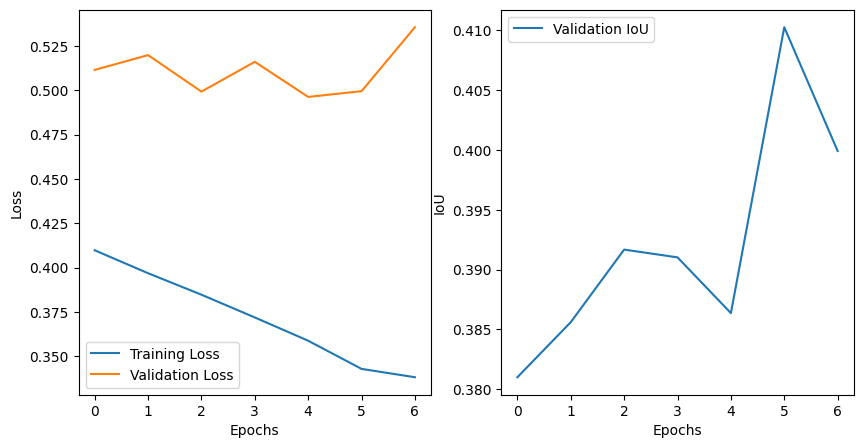

In [65]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(tloss, label='Training Loss')
ax[0].plot(vloss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(viou, label='Validation IoU')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('IoU')
ax[1].legend()

plt.show()

In [66]:
test_model = Model(unet, criterion, optimizer, device, metric)
test_loss, test_iou = test_model.test(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}")

Test Loss: 0.5137, Test IoU: 0.4040


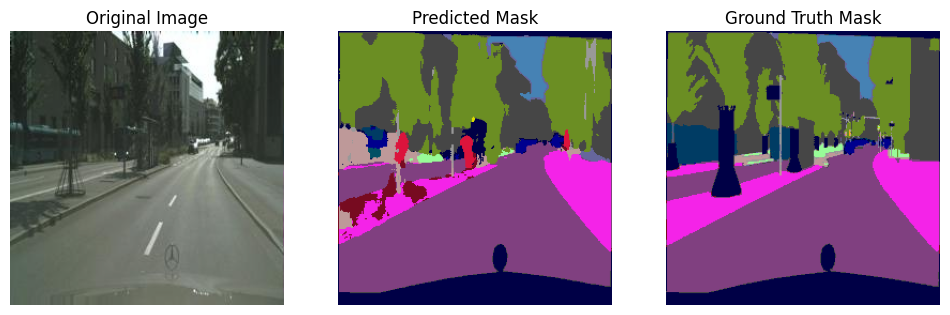

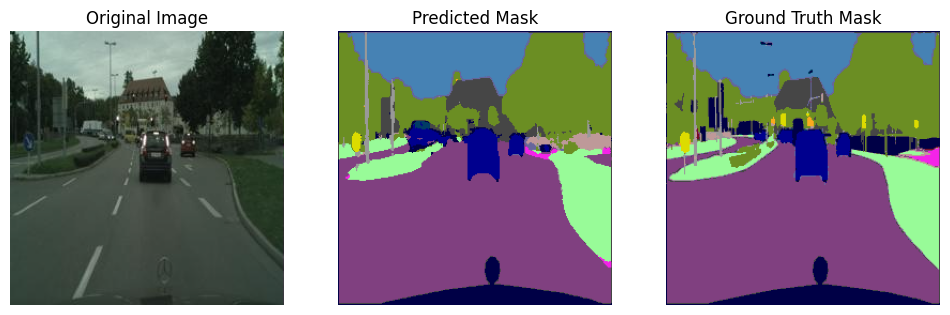

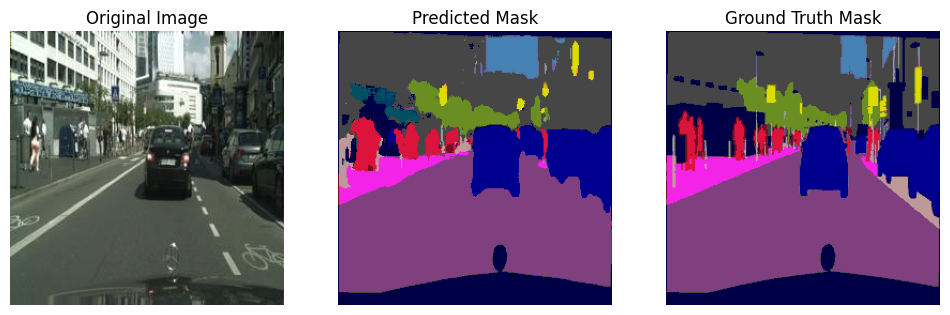

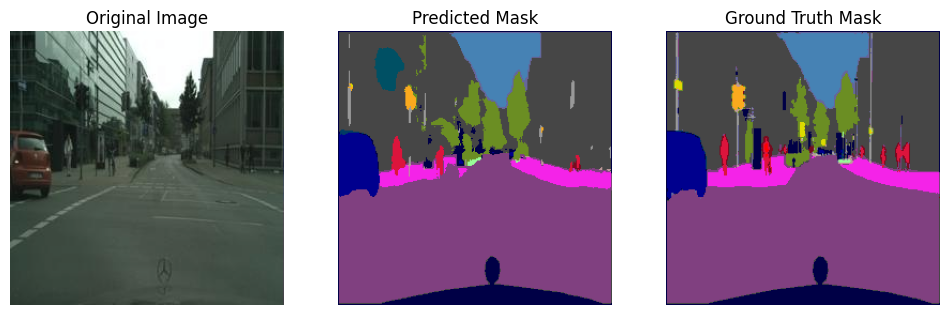

In [67]:
def plot_outputs(model, testloader, imgs=4):
    """
    Plot a few output images using the predicted outputs
    from the unet model.
    """


    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(testloader):
            if i >= imgs:
                break

            img = img.to(device)
            output = model(img)  # shape: (B, num_classes, H, W)



            # Move tensors to CPU and prepare for plotting
            img_np = img[0].cpu().numpy()  # take first image in batch
            img_np = np.transpose(img_np, (1, 2, 0))  # (H,W,C)

            # Denormalize the input images.
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])

            img_np = img[0].cpu().numpy()
            img_np = np.transpose(img_np, (1, 2, 0))
            img_np = (img_np * std) + mean  # denormalize
            img_np = np.clip(img_np, 0, 1)  # ensure values are in [0,1]


            # Get predicted mask
            pred = torch.argmax(output[0], dim=0).cpu().numpy()  # (H,W)
            pred_rgb = label_to_rgb(pred)

            # Ground truth mask
            mask_np = mask[0].cpu().numpy()  # (H,W)
            mask_rgb = label_to_rgb(mask_np)


            # Plot
            fig, ax = plt.subplots(1, 3, figsize=(12, 6))
            ax[0].imshow(img_np)
            ax[0].set_title("Original Image")
            ax[0].axis('off')

            ax[1].imshow(pred_rgb)
            ax[1].set_title("Predicted Mask")
            ax[1].axis('off')

            ax[2].imshow(mask_rgb)
            ax[2].set_title("Ground Truth Mask")
            ax[2].axis('off')

            plt.show()

plot_outputs(unet, test_loader)

